## Time to model. Going to attempt to compare performance of 4 classifiers: Logistic Regression, kNN, Random Forest, and Naive Bayes. I will begin by using the classifiers with their default parameters and two different word vectorizers: `CountVectorizer` and `TfidfVectorizer`. As noted in the EDA I will be setting the `min_df` to 4 in order to limit the feature space. I will move forward with the better performing vectorizer with default classifier settings, and grid search from there. 

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import ConfusionMatrixDisplay

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### Load data

In [195]:
data = pd.read_csv('../data/data_cleaned.csv', usecols=['subreddit','text', 'spacy', 'spacy_unique_word_count'])
data

,subreddit,text,spacy,spacy_unique_word_count
0,NoStupidQuestions,Are there laws on education in international w...,law on education in international water s...,21
1,NoStupidQuestions,Why can't some people not eat pork? Not be...,why not some people not eat pork not beca...,19
2,NoStupidQuestions,"Preference or Allergy Just wondering, now ...",preference or Allergy just wonder now whe...,25
3,NoStupidQuestions,Do I need to update card info on everything? ...,need to update card info on get a new car...,41
4,NoStupidQuestions,Any single ladies out there who wanna give an ...,any single lady out there give an ugly guy wit...,17
...,...,...,...,...
29591,AskReddit,"Im on a mission, down vote me to hell.",m on a mission down vote to hell,8
29592,AskReddit,LGBTQ+ community of Reddit what would you say ...,LGBTQ+ community of Reddit say the symbol of s...,13
29593,AskReddit,What is the most beautiful message you have ev...,the most beautiful message ever receive,6
29594,AskReddit,Are politics really getting increasingly polar...,politic really increasingly polarize or social...,15


#### Define X, y, get a baseline, then train-test-split

In [16]:
X = data.drop(columns=['subreddit', 'spacy_unique_word_count', 'text'])
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                              random_state=5,
                                              stratify=y)

print(f"Baseline: {y_train.value_counts(normalize=True).max()}")

# need to squeeze the X variables after including an extra column in the csv later in the analysis
X_train = X_train.squeeze()
X_test = X_test.squeeze()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Baseline: 0.5337658242104789


((22197,), (7399,), (22197,), (7399,))

#### Define pipelines for the two vectorizers combined with the four classifiers. 8 total

In [19]:
%%time
vects = zip([('cv', CountVectorizer(stop_words='english', min_df=4, ngram_range=(1,2)))]*4,\
            [('tfidf', TfidfVectorizer(stop_words='english', min_df=4, ngram_range=(1,2)))]*4)


classifiers = [('knn',KNeighborsClassifier()), ('logreg', LogisticRegression(random_state=5, max_iter=1000, n_jobs=-1)),
               ('rf', RandomForestClassifier(random_state=5, n_jobs=-1)), ('nb', MultinomialNB())]

pipes = []

for i, vect in enumerate(vects):
    pipes.append(Pipeline([vect[0], classifiers[i]]).fit(X_train,y_train))
    pipes.append(Pipeline([vect[1], classifiers[i]]).fit(X_train,y_train))

CPU times: user 2min 16s, sys: 1.68 s, total: 2min 18s
Wall time: 60 s


#### Now score each pipeline and put into dataframe for pleasant viewing

In [20]:
%%time
pipe_names = []
train_scores = []
test_scores = []
for pipe in pipes:
        pipe_names.append(f'{pipe.steps[0][0]}, {pipe.steps[1][0]}')
        train_scores.append(pipe.score(X_train, y_train))
        test_scores.append(pipe.score(X_test, y_test))
        
df = pd.DataFrame({
    'pipe': pipe_names,
    'train_scores': train_scores,
    'test_scores': test_scores
})

df

CPU times: user 45.3 s, sys: 8.81 s, total: 54.1 s
Wall time: 52.1 s


,pipe,train_scores,test_scores
0,"cv, knn",0.724963,0.617110
1,"tfidf, knn",0.699914,0.548047
2,"cv, logreg",0.761049,0.722260
3,"tfidf, logreg",0.839753,0.763211
4,"cv, rf",0.901473,0.688471
5,"tfidf, rf",0.994999,0.780241
6,"cv, nb",0.802766,0.739424
7,"tfidf, nb",0.812407,0.737938


#### With the exception of kNN, `TfidfVectorizer` outperforms `CountVectorizer`, or at least matches its performance. So now I will limit my models to using `TfidfVectorizer` and begin grid searches. 

In [21]:
# Just cleaning up memory a bit
del pipes
del classifiers
del vects

#### Beginning hyperparameter tuning

In [156]:
%%time
pipe_knn = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', min_df=4, ngram_range=(1,2))),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

params = {
    'knn__n_neighbors': [10, 20, 50, 100],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 3]
}

gs_knn = GridSearchCV(pipe_knn, params, n_jobs=-1, verbose=1)
gs_knn.fit(X_train, y_train)
print(gs_knn.best_params_)
gs_knn.score(X_train, y_train), gs_knn.score(X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__weights': 'distance'}
CPU times: user 49.3 s, sys: 10.4 s, total: 59.7 s
Wall time: 7min 51s


(0.9939180970401406, 0.5306122448979592)

#### kNN has repeatedly proven to be the worst performing, no matter how the hyperparameters are tuned. Can definitively say that there is no point in pursuing it further. 

In [157]:
%%time
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

params = {
    'tfidf__min_df': [4],
    'tfidf__max_df': [.1],
    'nb__alpha': [0.05040816326530612]
}

gs_nb = GridSearchCV(pipe_nb, params, n_jobs=-1, verbose=1)
gs_nb.fit(X_train, y_train)
print(gs_nb.best_params_)
gs_nb.score(X_train, y_train), gs_nb.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'nb__alpha': 0.05040816326530612, 'tfidf__max_df': 0.1, 'tfidf__min_df': 4}
CPU times: user 2.33 s, sys: 90 ms, total: 2.42 s
Wall time: 5.71 s


(0.8428165968374105, 0.7410460873090958)

#### Naive Bayes performs well, being able to reach >74% accuracy on the test set, and quickly runs through the GridSearch. I was able to achieve the lowest difference in train/test scores with this model, however the model was limited to unigrams. I think overall this version of the model shown is the best I was able to get it through this iteration. 

In [35]:
%%time
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', min_df=4, ngram_range=(1,2))),
    ('rf', RandomForestClassifier(random_state=5, n_jobs=-1, warm_start=True))
])

params = {
    'tfidf__max_df': [.09],
    'rf__n_estimators': [200],
    'rf__criterion': ['gini'],
    'rf__max_depth': [500],
    'rf__min_samples_leaf': [7]
}

gs_rf = GridSearchCV(pipe_rf, params, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_params_)
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'rf__criterion': 'gini', 'rf__max_depth': 500, 'rf__min_samples_leaf': 7, 'rf__n_estimators': 200, 'tfidf__max_df': 0.09}
CPU times: user 15.7 s, sys: 270 ms, total: 16 s
Wall time: 22.3 s


(0.7807811866468441, 0.7548317340181105)

#### Random Forest has achieved the highest overall test score of the bunch, at the cost of being the highest variance. However in this final iteration of tuning the `min_samples_leaf` parameter I was able to finally get the variance within that achieved by the Naive Bayes model, and it is now the best performing model of the bunch. The model shown above is the the lowest variance by far, and still achieves >75% accuracy (the best model with high variance only achieved ~79% accuracy, so I think this is an acceptable bias-variance trade-off)

In [40]:
%%time
pipe_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('logreg', LogisticRegression(max_iter=1e4, solver='saga', random_state=5, n_jobs=-1, warm_start=True))
])

params = {
    'tfidf__min_df': [4],
    'tfidf__max_df': [.1],
    'logreg__C': [3.747368421052632],
    'logreg__penalty': ['l2']
}

gs_logreg = GridSearchCV(pipe_logreg, params, n_jobs=-1, verbose=1)
gs_logreg.fit(X_train, y_train)
print(gs_logreg.best_params_)
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'logreg__C': 3.747368421052632, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__min_df': 4}
CPU times: user 2.76 s, sys: 116 ms, total: 2.88 s
Wall time: 7.67 s


(0.8876875253412624, 0.7622651709690499)

#### Logistic Regression performs well, but I cannot get the variance to get to a manageable level. Shown are the best parameters I was able to find. I will be moving forward with the Random Forest model only.

#### Attempting to use `ColumnTranformer` in order to incorporate status length into the classification. Going to only use Random Forest, and the best params I found previously

In [68]:
X_num = data.drop(columns=['subreddit', 'text'])
y_num = data['subreddit']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, 
                                              random_state=5,
                                              stratify=y_num)
X_train_num.shape, X_test_num.shape, y_train_num.shape, y_test_num.shape

In [69]:
%%time
cat_transformer = Pipeline([
    ('squeeze', FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=4, max_df=.09)),
    ('toarray', FunctionTransformer(lambda x: x.toarray()))
])
preprocessor = ColumnTransformer([
        ('ss', StandardScaler(), ['spacy_unique_word_count']),
        ('cat', cat_transformer, ['spacy']),
    ])

pipe_rf_num_ss = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=5, n_jobs=-1, warm_start=True,\
                                  n_estimators=200, min_samples_leaf=7, max_depth=500, criterion='gini'))
])

pipe_rf_num_ss

CPU times: user 73 µs, sys: 1 µs, total: 74 µs
Wall time: 77 µs


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['spacy_unique_word_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7faf22369940>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.09,
                                                                                   min_df=4,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7faf223698b0>))]),
                                                  ['spacy'])])),
                ('rf',
                 RandomForestClassifier(max_depth=500, min_samples_leaf=7,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=5, warm_start=True))])

In [70]:
%%time
pipe_rf_num_ss.fit(X_train_num, y_train_num)
pipe_rf_num_ss.score(X_train_num, y_train_num), pipe_rf_num.score(X_test_num, y_test_num)

CPU times: user 18min 8s, sys: 12.3 s, total: 18min 21s
Wall time: 5min 17s


(0.7836194080281119, 0.7672658467360454)

#### Wow that's a long time for a single fit, but brought down the variance even more and increased the accuracy! In theory scaling shouldn't be required since this is a classification problem, so going to investigate not including StandardScaler.

In [72]:
%%time
cat_transformer = Pipeline([
    ('squeeze', FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=4, max_df=.09)),
    ('toarray', FunctionTransformer(lambda x: x.toarray()))
])
preprocessor = ColumnTransformer([
        ('cat', cat_transformer, ['spacy']),
    ])

pipe_rf_num = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=5, n_jobs=-1, warm_start=True,\
                                  n_estimators=200, min_samples_leaf=7, max_depth=500, criterion='gini'))
])

pipe_rf_num

CPU times: user 67 µs, sys: 1e+03 ns, total: 68 µs
Wall time: 71 µs


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fae4769d1f0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.09,
                                                                                   min_df=4,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fae4769d430>))]),
                                                  ['spacy'])])),
                ('rf',
                 RandomForestClassifier(max_depth=500, min_samples_leaf=7,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=5, warm_start=True))])

In [74]:
%%time
pipe_rf_num.fit(X_train_num, y_train_num)
pipe_rf_num.score(X_train_num, y_train_num), pipe_rf_num.score(X_test_num, y_test_num)

CPU times: user 18min 50s, sys: 11 s, total: 19min 1s
Wall time: 5min 28s


(0.7807811866468441, 0.7548317340181105)

#### So scaling did help. Going to see if I can reduce `min_samples_leaf` and increase accuracy.

In [81]:
%%time
cat_transformer = Pipeline([
    ('squeeze', FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=4, max_df=.09)),
    ('toarray', FunctionTransformer(lambda x: x.toarray()))
])
preprocessor = ColumnTransformer([
        ('ss', StandardScaler(), ['spacy_unique_word_count']),
        ('cat', cat_transformer, ['spacy']),
    ])

pipe_rf_num_ss = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=5, n_jobs=-1, warm_start=True,\
                                  n_estimators=200, min_samples_leaf=3, max_depth=1000, criterion='gini'))
])

pipe_rf_num_ss.fit(X_train_num, y_train_num)
pipe_rf_num_ss.score(X_train_num, y_train_num), pipe_rf_num.score(X_test_num, y_test_num)

CPU times: user 18min 24s, sys: 12.4 s, total: 18min 36s
Wall time: 5min 37s


(0.8334009100328873, 0.7548317340181105)

#### Played around here a bit, the initial parameters held up as best.

In [97]:
%%time
from scipy.sparse import csr_matrix # can't pickle lambda functions, so had to import this and pass to FunctionTransformer
cat_transformer = Pipeline([
    ('squeeze', FunctionTransformer(np.squeeze)),
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=4, max_df=.09)),
    ('toarray', FunctionTransformer(csr_matrix.toarray))
])
preprocessor = ColumnTransformer([
        ('ss', StandardScaler(), ['spacy_unique_word_count']),
        ('cat', cat_transformer, ['spacy']),
    ])

pipe_rf_num_ss = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=5, n_jobs=-1, warm_start=True,\
                                  n_estimators=200, min_samples_leaf=7, max_depth=500, criterion='gini'))
])

pipe_rf_num_ss

CPU times: user 95 µs, sys: 1e+03 ns, total: 96 µs
Wall time: 103 µs


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['spacy_unique_word_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function squeeze at 0x7faf37da65e0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.09,
                                                                                   min_df=4,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english')),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function _cs_matrix.toarray at 0x7faf3a4255e0>))]),
                                                  ['spacy'])])),
                ('rf',
                 RandomForestClassifier(max_depth=500, min_samples_leaf=7,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=5, warm_start=True))])

In [98]:
%%time
pipe_rf_num_ss.fit(X_train_num, y_train_num)
pipe_rf_num_ss.score(X_train_num, y_train_num), pipe_rf_num_ss.score(X_test_num, y_test_num)

CPU times: user 14min 31s, sys: 10.4 s, total: 14min 42s
Wall time: 4min 25s


(0.7836194080281119, 0.7672658467360454)

#### Saving this as the best model

In [99]:
with open('../output/best_model.pkl', 'wb') as f:
    pickle.dump(pipe_rf_num_ss, f)

#### Let's look at the confusion matrix and pull out some successful cases.

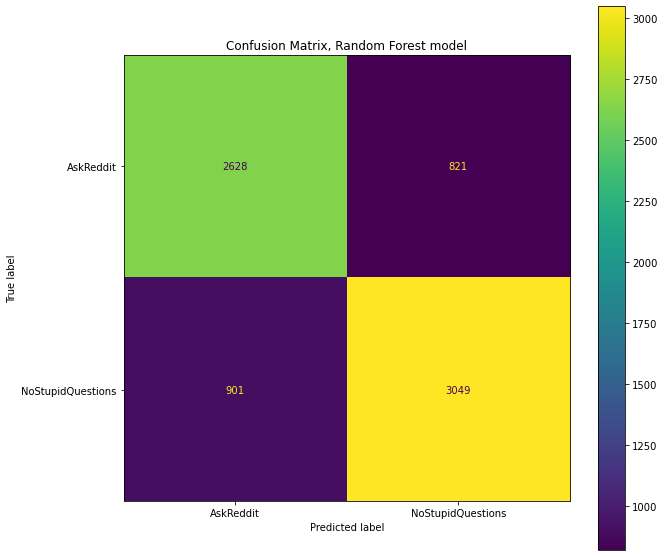

In [110]:
fig, ax = plt.subplots(figsize=(10,10))
y_pred = pipe_rf_num_ss.predict(X_test_num)
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred, ax=ax)
plt.title('Confusion Matrix, Random Forest model');

In [188]:
901/(821+901)

0.5232288037166086

#### Slightly more AskReddit predictions than NoStupidQuestions, but the difference is very close to the initial distribution of the population.

#### Looking at examples of successes/failures

In [211]:
y_pred = pd.DataFrame(y_pred, columns=['prediction'], index=y_test.index)
rf_out = pd.concat([y_test_num,y_pred], axis=1)
pd.concat([X_test_num[rf_out['subreddit']==rf_out['prediction']], \
                 y_test_num[rf_out['subreddit']==rf_out['prediction']]], axis=1).head(20)

,spacy,spacy_unique_word_count,subreddit
28948,ZkSync crypto airdrop,3,AskReddit
19217,want to brag about for a while but just not ha...,13,AskReddit
5554,why not the counterfeiting of US Currency More...,53,NoStupidQuestions
20086,serious as an adult how deal with a parent an ...,12,AskReddit
12969,why people watch Mukbangs seriously get n...,27,NoStupidQuestions
7020,girl smart than Boys but why boy pay more than...,15,NoStupidQuestions
3984,why not people allow to use self defense again...,59,NoStupidQuestions
19976,paramedic bad story from album,5,AskReddit
1898,how deal with the pain of u recruit love ...,36,NoStupidQuestions
16070,how to Reddit for dummies?!🥲,5,AskReddit


In [207]:
data['text'][12969]

"Why do people watch Mukbangs?     I seriously get nauseous just looking at the thumbnails for these videos. And from what I know, the videos themselves are super messy. I just don't see what type of entertainment people get out of these videos."

In [213]:
data['text'][16350]

"What's the funniest way to die?     "

In [203]:
pd.concat([X_test_num[rf_out['subreddit']!=rf_out['prediction']],\
           y_test_num[rf_out['subreddit']!=rf_out['prediction']]], axis=1)

,spacy,spacy_unique_word_count,subreddit
19161,hey need Twitter follower increase help,6,AskReddit
13196,how repulsive man rape to woman,6,NoStupidQuestions
10480,when cheating happen the fault of the married ...,10,NoStupidQuestions
11483,why the song Toy Box Tarzan and Jane stick in ...,11,NoStupidQuestions
29523,[ serious ] how a person go about legally and ...,18,AskReddit
...,...,...,...
8538,why hate pinapple on pizza love,6,NoStupidQuestions
24508,view on the male social hierarchy e.g Sigma be...,11,AskReddit
10846,why do gay man like short guy,7,NoStupidQuestions
12212,some red flag when meet new,6,NoStupidQuestions


In [208]:
data['text'][10480]

'When cheating happens, is it the fault of the married man or the mistress?     '

In [209]:
data['text'][24508]

'What is your view on the male social hierarchy? (e.g, Sigma, beta and alpha male).     '

#### Getting most import features from the model

In [185]:
pd.DataFrame(pipe_rf_num_ss.named_steps.rf.feature_importances_,\
             index=['spacy_unique_word_count']+list(preprocessor.named_transformers_.cat[-2].get_feature_names_out())).sort_values(by=0, ascending=False).head(20)

,0
spacy_unique_word_count,0.214312
reddit,0.028165
good,0.017278
thing,0.015590
mean,0.013641
say,0.013304
really,0.013071
use,0.012624
favorite,0.011867
work,0.010511


#### Compiling the train/test scores for all the models into a dataframe

In [ ]:
models = np.array([['kNN',gs_knn], ['Naive Bayes', gs_nb], ['Logistic Regression', gs_logreg], ['Random Forest', pipe_rf_num_ss]]).reshape(4,2)
models[:,0]
train_scores = []
test_scores = []
for model in models:
    if model[0] != 'Random Forest':
        train_scores.append(model[1].score(X_train, y_train))
        test_scores.append(model[1].score(X_test, y_test))
    else:
        train_scores.append(model[1].score(X_train_num, y_train_num))
        test_scores.append(model[1].score(X_test_num, y_test_num)) 

In [178]:
df = pd.DataFrame({
    'model': models[:,0],
    'train_scores': train_scores,
    'test_scores': test_scores,
})

df.set_index('model', drop=True).round(3)

,train_scores,test_scores
model,,
kNN,0.994,0.531
Naive Bayes,0.843,0.741
Logistic Regression,0.888,0.762
Random Forest,0.784,0.767
